# Introduction to Differential Privacy (DP) with Federated Learning.

This tutorial aims to show you how easy it is to use differential privacy (DP) using `pfl`.

This tutorial will cover:
- Necessity of DP for FL.
- Instantiating and using DP mechanisms with `pfl`.
- Details of what's happening when using DP with FL.
- Impact of using DP with FL.
- Tuning DP hyperparameters.

## 1. Necessity of DP in FL.

Federated learning (FL) minimizes the amount of data sent from user devices to the server by only sending model updates from user devices, rather than the full data of each user. However, FL still does not provide any privacy guarantees to the individual, and there has been much work showing the success of running membership inference attacks, reconstruction attacks and other types of attacks on models trained using FL without DP. [Zhu et al.](https://arxiv.org/abs/1906.08935) showed that training data can be reconstructed from publicly shared gradients for image classification and masked language modelling tasks. Data reconstruction attacks during FL when no DP is used have been widely explored in the literature, for example on image classification tasks by [Boenisch et al.](https://arxiv.org/abs/2112.02918).

DP can be used to provide formal privacy guarantees to users, or to individual datapoints, to mitigate the aforementioned privacy attacks.

In general, we recommend using DP to provide privacy guarantees to users in a dataset. User-level DP is explained in more detail by [Levy et al.](https://arxiv.org/pdf/2102.11845.pdf) and [McMahan et al.](https://arxiv.org/pdf/1710.06963.pdf)

## 2. How to instantiate and use DP mechanisms with `pfl`.

The steps involved in using DP with `pfl`, where we assume you are protecting the privacy of users in a dataset:
1. Decide on the DP setup to use: local DP or central DP  guarantees; which noise mechanism; whether to use an accountant for efficient privacy composition if multiple iterations are to be performed. The recommended DP setup is Gaussian mechanism central mechanism applied locally, using PLD privacy accountant or DP-FTRL.
3. Define the privacy mechanism to use: define directly using classes in `pfl.privacy`, or use the helper function `utils.argument_parsing.parse_mechanism`.
4. Include privacy mechanism(s) in postprocessors list in `Backend`. Note if not doing simulations with SimulatedBackend, you will need to implement client-side logic yourself.
5. Run algorithm as normal, with `algorithm.run()` where `backend` is an input parameter.

### 2.1 Decide on the type of DP to use.

#### Local DP vs. central DP.

DP can be applied locally (on the user's device: users do not need to trust a server to apply DP), or centrally (on the server aggregating contributions from users: this requires users to trust that the server will correctly add the required DP noise).

Local DP is a stronger privacy guarantee than central DP since it does not require users to trust that the aggregation server will correctly apply DP noise and, for the same privacy parameters, local DP will require more DP noise to be added in total across all users compared to central DP.

It should be noted that central DP can be implemented in a distributed way, such that a portion of the central DP noise is added locally by each user to their own statistics before aggregation. This removes the need for users to trust an aggregation server to correctly apply central DP noise. Adding central DP noise in a distributed way is easily achieved when using the Gaussian noise mechanism: each user adds DP noise with variance $\sigma^2/N$, where $\sigma^2$ is the variance of the DP noise that would be added centrally and $N$ is the total number of users over which to aggregate contributions.

We show that the distribution of the added noise is the same whether Gaussian $N(0, \sigma^2)$ DP noise is added centrally by a trusted aggregation server or, in a distributed way, $N(0, \sigma^2/N)$ DP noise is added locally on N user devices.

Text(0.5, 1.0, 'Compare central DP noise applied centrally vs.\nlocally on user devices before aggregation')

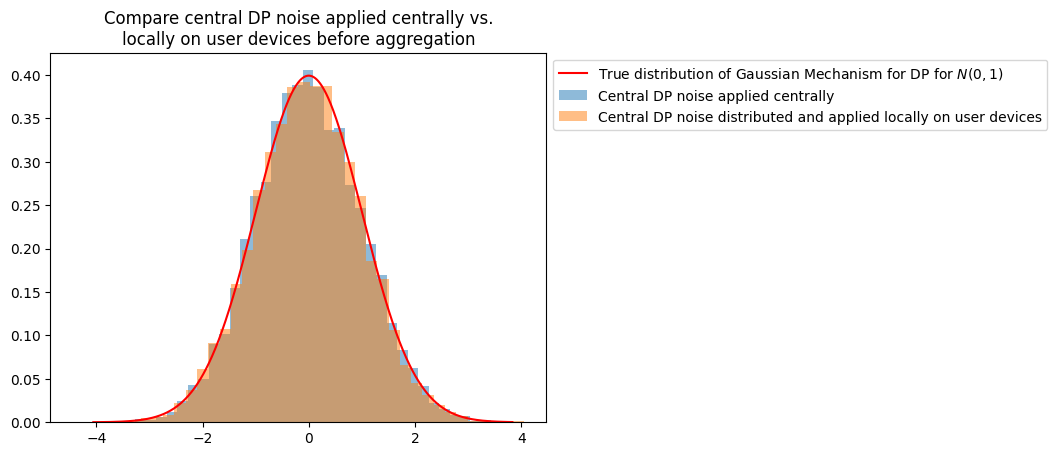

In [2]:
import math
import numpy as np
from scipy.stats import norm 
import matplotlib.pyplot as plt
#sys.path.append('../') # add pfl-research to pythonpath
#sys.path.append('../benchmarks') # add pfl-research/benchmarks to pythonpath 
# Both Jupyter and `pfl` use async. `nest_asyncio` allows `pfl` to run inside the notebook 
import nest_asyncio
nest_asyncio.apply()

sigma = 1
num_repeats = 10000
central_noise = np.random.normal(0, sigma, size=(num_repeats,))

num_users = 1000
local_noise = np.random.normal(0, sigma/math.sqrt(num_users), size=(num_repeats, num_users))
aggregated_local_noise = np.sum(local_noise, axis=1)

x = np.linspace(np.min(central_noise), np.max(central_noise), 1000)
plt.plot(x, norm.pdf(x, 0, sigma), color='red', label='True distribution of Gaussian Mechanism for DP for $N(0,1)$') 

plt.hist(central_noise, density=True, bins=40, alpha=0.5, label='Central DP noise applied centrally')
plt.hist(aggregated_local_noise, density=True, bins=40, alpha=0.5, label='Central DP noise distributed and applied locally on user devices')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Compare central DP noise applied centrally vs.\nlocally on user devices before aggregation')

#### Which DP noise mechanism to use.

In this notebook, we shall use the Gaussian DP noise mechanism. The Gaussian noise mechanism provides approximate $\left(\epsilon, \delta\right)$-DP, where $\epsilon$ is the privacy loss parameter and $\delta$ is the probability of all privacy being lost. 

When using the Gaussian distribution, the noise added for DP will be drawn from a Gaussian distribution. The mean of this noise will be zero, and the standard deviation of this noise will be directly proportional to the clipping bound used to constrain the sensivity of the vector being privatised, and is a function of the privacy parameters $\epsilon$ and $\delta$.

Below we show: the instantiation of the Gaussian mechanism; how to add DP noise to statistics using the Gaussian mechanism in `pfl`; and we show the distribution of the added DP noise on the statistics.

In [4]:
import multiprocessing
# Set multiprocessing start method to "spawn" instead of forkserver (which is the default)
# That is because forkserver does not work on Windows, but spawn does.
def init_multiprocessing():
    try:
        multiprocessing.set_start_method("spawn", force=True)  # Forces "spawn"
    except RuntimeError:
        pass  # Ignore if it's already set

init_multiprocessing()

import os
from pfl.internal.ops import pytorch_ops
from pfl.internal.ops.selector import set_framework_module

os.environ['PFL_PYTORCH_DEVICE'] = 'cpu'
set_framework_module(pytorch_ops)

import numpy as np
import torch

from pfl.stats import MappedVectorStatistics
from pfl.privacy import GaussianMechanism

from utils.argument_parsing import parse_mechanism

torch.random.manual_seed(1)
np.random.seed(1)

# Define the Gaussian mechanism, use it to add noise to a vector of data, and show the mean and variance of the noise added

epsilon = 1
delta = 1e-8
cohort_size = 100
num_epochs = 1
population = cohort_size
clipping_bound = 2

gaussian_privacy = GaussianMechanism.construct_single_iteration(clipping_bound=clipping_bound, epsilon=epsilon, delta=delta)

# note that this can also be defined using the helper function
# gaussian_privacy = parse_mechanism(
#    mechanism_name='gaussian',
#    clipping_bound=clipping_bound,
#    epsilon=epsilon,
#    delta=delta)

# add the DP noise to 10000 random values
num_stats = 10000
statistics = MappedVectorStatistics({'stats': torch.randn(num_stats)})
noisy_statistics, metrics = gaussian_privacy.add_noise(statistics=statistics, cohort_size=1)

noise = noisy_statistics['stats'] - statistics['stats']

# report basic statistics about the added DP noise
noise_mean = torch.mean(noise)
noise_std_dev = torch.std(noise)
print(f'The empirical mean of the Gaussian noise added {num_stats} times = {noise_mean:.4f}')
print(f'The empirical standard deviation of the Gaussian noise added {num_stats} times = {noise_std_dev:.4f}')

# plot distribution of added DP noise
import matplotlib.pyplot as plt
plt.hist(noise, bins=60, density=True, label='Empirical distribution of Gaussian noise added for DP')

# Plot target Gaussian distribution of DP noise added: zero mean, std. dev. = clipping_bound * gaussian_privacy.relative_noise_stddev
gaussian_mean = 0
gaussian_std_dev = clipping_bound * gaussian_privacy.relative_noise_stddev
print(f'The true standard deviation of the noise generated using the Gaussian mechanism = {gaussian_std_dev:.4f}')
x = np.linspace(torch.min(noise), torch.max(noise), 1000)
plt.plot(x, norm.pdf(x, gaussian_mean, gaussian_std_dev), color='red', label='True distribution of Gaussian Mechanism for DP') 

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title(f'Probability distribution of DP noise added {num_stats} times')

ModuleNotFoundError: No module named 'utils'

The Laplace mechanism is also supported in `pfl`. Below we plot the empirical distribution of DP noise added using the Laplace mechanism, as well as the true distribution of DP noise generated using the Laplace mechanism.

For further information about the foundations of differential privacy, you can read the book "The Algorithmic Foundations of Differential Privacy" by Cynthia Dwork and Aaron Roth.

Text(0.5, 1.0, 'Distribution of noise mechanisms')

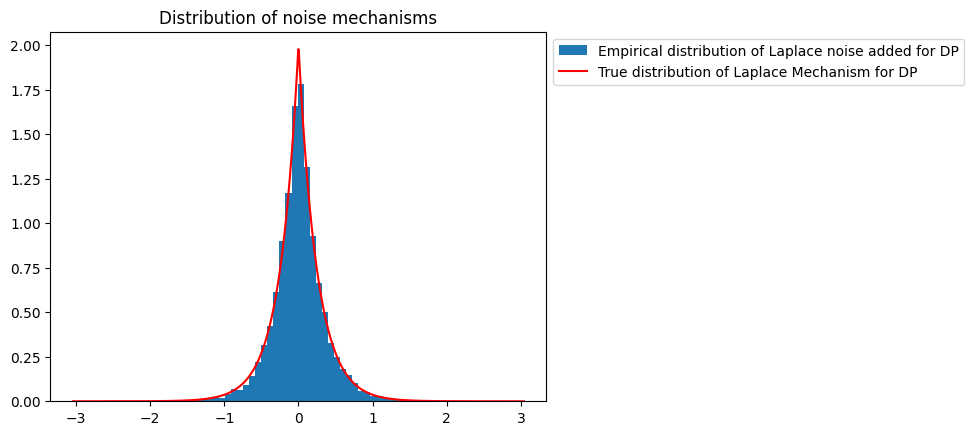

In [6]:
from pfl.privacy import LaplaceMechanism

clipping_bound = 0.5
epsilon = 2

# statistics to which to add DP noise
num_stats = 10000
statistics = MappedVectorStatistics({'stats': torch.randn(num_stats)})

# define laplace mechanism
laplace_mechanism = LaplaceMechanism(clipping_bound=clipping_bound, epsilon=epsilon)
laplace_noisy_statistics, metrics = laplace_mechanism.add_noise(statistics=statistics, cohort_size=1)
laplace_noise = laplace_noisy_statistics['stats'] - statistics['stats']

plt.hist(laplace_noise, bins=60, density=True, label='Empirical distribution of Laplace noise added for DP')
from scipy.stats import laplace
bound = max(abs(torch.min(laplace_noise)), abs(torch.max(laplace_noise)))
x_laplace = np.linspace(-bound, bound, 1000)
plt.plot(x_laplace, laplace.pdf(x_laplace, 0, clipping_bound/epsilon), color='red', label='True distribution of Laplace Mechanism for DP') 

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Distribution of noise mechanisms')

#### Using a privacy accountant

Privacy leakage accumulates over multiple independent accesses to the same data. During FL, many iterations of training take place to train a model. On each iteration, the aggregation of data from users incurs privacy loss. The privacy loss composes, or accumulates, over the multiple iterations of training. When applying DP to FL, we must consider the total privacy loss over all iterations of training. A privacy accountant can be used to compute the total privacy loss given the total number of iterations of training to be performed, the sampling rate of user devices in each iteration, the noise mechanism to use to apply DP, and the desired privacy parameters $\epsilon$ and $\delta$ for the total PFL (Private FL) training experiment.

A privacy accountant will compute the DP noise to be added such that the overall privacy loss across iterations is accurate. We recommend using the PLD privacy accountant (`pfl.privacy.PLDPrivacyAccountant`), PRV privacy accountant (`pfl.privacy.PRVPrivacyAccountant`), or RDP privacy accountant (`pfl.privacy.RDPPrivacyAccountant`). Alternatively, a private optimization algorithm such as MF-DP-FTRL (`pfl.privacy.ftrl_mechanism.BandedMatrixFactorizationMechanism`) can be used to minimize the overall DP noise error during training.

In [7]:
# Define Gaussian DP mechanisms for central DP guarantees using three different methods

clipping_bound = 0.5
epsilon = 2
delta = 1e-8
cohort_size = 100
num_epochs = 100
sampling_probability = 1e-4
is_central = True

In [8]:
# define a Gaussian DP mechanism using the PLD privacy accountant
# WARNING: it takes a while for the gaussian_moments_accountant mechanism to be instantiated

from pfl.privacy import (PLDPrivacyAccountant, CentrallyAppliedPrivacyMechanism)

# define the PLD privacy accountant, which will use the Gaussian noise mechanism
pld_accountant = PLDPrivacyAccountant(
    num_compositions=num_epochs,
    sampling_probability=sampling_probability,
    mechanism='gaussian',
    epsilon=epsilon,
    delta=delta)

# instantiate a Gaussian noise mechanism using the privacy accountant
pld_gaussian_noise_mechanism = GaussianMechanism.from_privacy_accountant(
    accountant=pld_accountant, clipping_bound=clipping_bound)

# wrap the noise mechanism with CentrallyAppliedPrivacyMechanism to make it a central privacy mechanism
pld_central_privacy = CentrallyAppliedPrivacyMechanism(pld_gaussian_noise_mechanism)

# note that this can also be defined using the helper function utils.arguments.parse_mechanism
# pld_central_privacy = parse_mechanism(
#    mechanism_name='gaussian_moments_accountant',
#    epsilon=epsilon,
#    clipping_bound=clipping_bound,
#    delta=delta,
#    cohort_size=cohort_size,
#    num_epochs=num_epochs,
#    population=cohort_size / sampling_probability,
#    is_central=is_central)

In [9]:
# define a Gaussian DP mechanism which is naively composed: 
# if total privacy loss is epsilon, then privacy loss per iteration must be epsilon / num_epochs, where num_epochs is total number of iterations to run
epsilon_naive_composition = epsilon / num_epochs

naive_gaussian_privacy = GaussianMechanism.construct_single_iteration(clipping_bound=clipping_bound, epsilon=epsilon_naive_composition, delta=delta)

naive_central_privacy = CentrallyAppliedPrivacyMechanism(naive_gaussian_privacy)

# note that this can also be defined using the helper function utils.arguments.parse_mechanism
# naive_central_privacy = parse_mechanism(
#    mechanism_name='gaussian',
#    clipping_bound=clipping_bound,
#    epsilon=epsilon_naive_composition,
#    delta=delta,
#    is_central=is_central)

In [10]:
# Define Gaussian DP mechanism using banded MF-DP-FTRL
# WARNING: it takes a while for the banded_matrix_factorization mechanism to be instantiated

import os
import math

from pfl.privacy.ftrl_mechanism import BandedMatrixFactorizationMechanism

# WARNING: for MF-DP-FTRL a strict client participation schema must be adhered to to ensure that a pre-defined 
# minimum number of iterations of separation between a client participating in training (min_separation) is adhered to
min_separation = math.ceil((cohort_size / sampling_probability) / num_epochs) # assume participation of clients is maximally spaced out across iterations
print(f'min_separation: {min_separation}')

make_privacy_accountant = lambda num_compositions: PLDPrivacyAccountant(
    num_compositions,
    sampling_probability=sampling_probability,
    mechanism='gaussian',
    epsilon=epsilon,
    delta=delta)

banded_mf_mechanism = BandedMatrixFactorizationMechanism(
    clipping_bound, num_epochs, min_separation,
    make_privacy_accountant)

banded_mf_central_privacy = CentrallyAppliedPrivacyMechanism(banded_mf_mechanism)

# note that this can also be defined using the helper function utils.arguments.parse_mechanism
# ftrl_central_privacy = parse_mechanism(
#    mechanism_name='banded_matrix_factorization',
#    clipping_bound=clipping_bound,
#    epsilon=epsilon,
#    delta=delta,
#    cohort_size=cohort_size,
#    num_epochs=num_epochs,
#    population=population,
#    min_separation=min_separation,
#    is_central=is_central)

min_separation: 10000


In [11]:
print(f'Std. dev. of DP noise using FTRL with banded matrix factorisation: {banded_mf_central_privacy.underlying_mechanism.relative_noise_stddev:.4f}')
print(f'Std. dev. of DP noise using PLD privacy accountant: {pld_central_privacy.underlying_mechanism.relative_noise_stddev:.4f}')
print(f'Std. dev. of DP noise using naive composition with Gaussian mechanism: {naive_central_privacy.underlying_mechanism.relative_noise_stddev:.4f}')

Std. dev. of DP noise using FTRL with banded matrix factorisation: 0.4208
Std. dev. of DP noise using PLD privacy accountant: 0.4975
Std. dev. of DP noise using naive composition with Gaussian mechanism: 213.3748


You can see that the standard deviation of the DP noise to be added is much smaller when computed using banded MF-DP-FTRL privacy optimization algorithm, or when computed using the PLD privacy accountant. By contrast, if the Gaussian mechanism was naively composed (by summing the privacy loss across all iterations), the standard deviation of the DP noise to be added for the same privacy parameters would be 507 times, and 429 times, greater than using the MF-DP-FTRL algorithm or the PLD privacy accountant respectively.

Note that in the above example subsampling of clients in each iteration is being used: 0 < sampling_probability < 1, which means that not all clients participate in each iteration of training. Subsampling causes amplification of the privacy guarantees: lower sampling rates increase the privacy guarantees, thereby lowering the standard deviation of the DP noise to be added. Subsampling improves the utility of results produced with DP, however, one should note that is can be challenging to ensure that a fixed sampling rate is used in practical PFL systems.

#### Recommendation of DP settings for PFL training

We recommend using user-level DP for PFL training, and achieving this using a privacy accountant such as PLDPrivacyAccountant or using the banded MF-DP-FTRL algorithm with the Gaussian mechanism, depending on whether sampling probabilities and client participation settings can be guaranteed. We recommend providing central DP user-level guarantees with PFL. However, it should be noted that the DP noise for central DP can be added locally on user devices so that the central aggregation server does not have to be trusted by users to apply DP noise correctly.

Note that `pfl` is setup to apply DP at the user level by default. All privacy mechanisms inherit from `LocalPrivacyMechanism` or from `CentrallyAppliedPrivacyMechanism`. Both of these classes have the two following methods to: 
1. Apply required DP operations to the data of each user: `postprocess_one_user(*, stats: TrainingStatistics, user_context: UserContext) -> Tuple[TrainingStatistics, Metrics]`
2. Apply required DP operations to the aggregated data:`postprocess_server(*, stats: TrainingStatistics, central_context: CentralContext, aggregate_metrics: Metrics) -> Tuple[TrainingStatistics, Metrics]`

### 2.2 Define the DP mechanism to use

A useful function to instantiate privacy mechanisms, called `parse_mechanism()` is provided in `utils.argument_parsing`.

Next, we instantiate a privacy mechanism using `utils.argument_parsing.parse_mechanism` and show how this mechanism is used to process the data of each user, and to process the data aggregated over all users, to provide central DP guarantees.

In [12]:
# show what happens locally on each user's data when central DP is applied
# there is no change to the data if the sensitivity (l2 norm) of the data is <= clipping bound
#n note that for central DP, each user's data is only scaled so its sensitivity is <= clipping bound. Noise is not yet added.
from pfl.context import UserContext, CentralContext
from pfl.common_types import Population

from utils.argument_parsing import parse_mechanism

import numpy as np
import torch

# define user data
# set small clipping bound = sensitivity of user data / 2
# set large clipping bound = sensitivity, so there will be no change to data with large clipping bound
user_data = torch.randn(10)
sensitivity = torch.linalg.norm(user_data, ord=2)
small_clipping_bound = sensitivity / 2
large_clipping_bound = sensitivity

In [13]:
# WARNING: instantiation of the two privacy mechanisms (central_privacy_small_clipping and central_privacy_large_clipping) will take some time.

# define Gaussian DP mechanisms using large and small clipping bounds
epsilon = 2
delta = 1e-8
cohort_size = 100
num_epochs = 100
population = 1e6
is_central = True

central_privacy_small_clipping = parse_mechanism(
    mechanism_name='gaussian_moments_accountant',
    clipping_bound=small_clipping_bound,
    epsilon=epsilon,
    delta=delta,
    cohort_size=cohort_size,
    num_epochs=num_epochs,
    population=population,
    is_central=is_central)
print('Defined central_privacy_small_clipping')

central_privacy_large_clipping = parse_mechanism(
    mechanism_name='gaussian_moments_accountant',
    clipping_bound=large_clipping_bound,
    epsilon=epsilon,
    delta=delta,
    cohort_size=cohort_size,
    num_epochs=num_epochs,
    population=population,
    is_central=is_central)
print('Defined central_privacy_large_clipping')

Defined central_privacy_small_clipping
Defined central_privacy_large_clipping


Sensivity of original data: tensor(2.1256)
Small clipping bound: tensor(1.0628)
Sensivity of noised data using large clipping bound - no change: tensor(2.1256)
Sensivity of noised data using small clipping bound - scaled to the clipping bound 1.0627756118774414: tensor(1.0628)


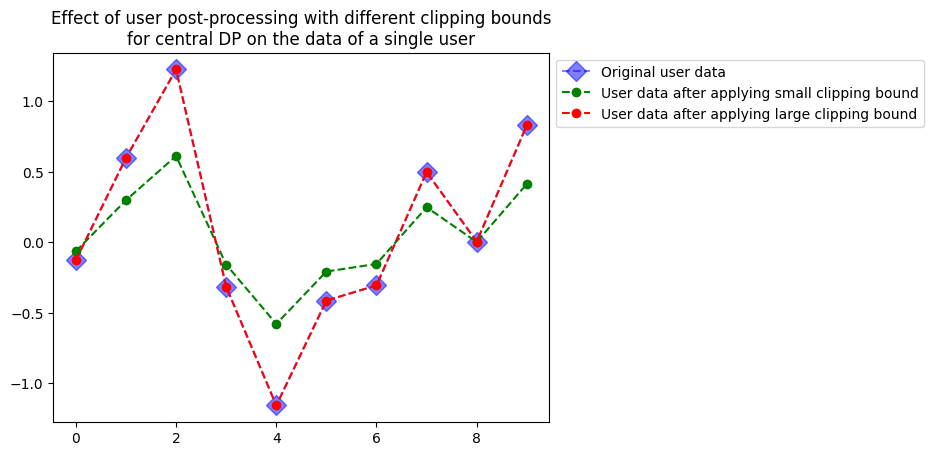

In [14]:
# apply postprocess_one_user() function to user's data using two privacy mechanisms defined with different clipping bounds

user_statistics = MappedVectorStatistics({'weights': user_data})
user_context = UserContext(num_datapoints=4, seed = 1)

noised_statistics_small_clipping, _ = central_privacy_small_clipping.postprocess_one_user(stats=user_statistics, user_context=user_context)
noised_statistics_large_clipping, _ = central_privacy_large_clipping.postprocess_one_user(stats=user_statistics, user_context=user_context)

# Print the resulting sensitivity of the data
print('Sensivity of original data:', torch.linalg.norm(user_statistics['weights'], ord=2))
print('Small clipping bound:', small_clipping_bound)
print('Sensivity of noised data using large clipping bound - no change:', torch.linalg.norm(noised_statistics_large_clipping['weights'], ord=2))
print(f'Sensivity of noised data using small clipping bound - scaled to the clipping bound {small_clipping_bound}:', torch.linalg.norm(noised_statistics_small_clipping['weights'], ord=2))

# Plot the original data and clipped data
plt.plot(user_statistics['weights'], 'D--', markersize=10, color='blue', alpha=0.5, label='Original user data')
plt.plot(noised_statistics_small_clipping['weights'], 'o--', color='green', label='User data after applying small clipping bound')
plt.plot(noised_statistics_large_clipping['weights'], 'o--', color='red', label='User data after applying large clipping bound')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
_ = plt.title('Effect of user post-processing with different clipping bounds\nfor central DP on the data of a single user')

Central DP is being used here, so `postprocess_one_user()` only rescales the sensitivity (l2 norm) of a user's data to the clipping bound. Note that in central DP, DP noise is only added to the aggregate over all user's data in the function `postprocess_server()`.

The `cohort_size` is set to 100 so let's aggregate the data of 100 users and see the effect of adding central DP noise in the case where a large clipping bound and a small clipping bound are used.

Note that the `seed` used in `UserContext` is different for each client. The seed is typically yielded by a `FederatedDataset` along with the raw data for that user. In this example we just let the seed equal the index of the user.

In [15]:
true_user_statistics = user_statistics
noised_aggregated_data_small_clipping = noised_statistics_small_clipping
noised_aggregated_data_large_clipping = noised_statistics_large_clipping

for i in range(cohort_size - 1):
    user_context = UserContext(num_datapoints=4, seed=i)
    
    user_statistics = MappedVectorStatistics({'weights': torch.randn(10)})
    true_user_statistics += user_statistics

    # do local operations for central DP (just clipping) on user data using large and small clipping bounds
    noised_statistics_small_clipping, _ = central_privacy_small_clipping.postprocess_one_user(stats=user_statistics, user_context=user_context)
    noised_statistics_large_clipping, _ = central_privacy_large_clipping.postprocess_one_user(stats=user_statistics, user_context=user_context)
    
    # aggregate noised data
    noised_aggregated_data_small_clipping += noised_statistics_small_clipping
    noised_aggregated_data_large_clipping += noised_statistics_large_clipping

Next we use the function `postprocess_server()` and see the effects of the server-side operation, which adds noise to the aggregated result.

In [16]:
# apply server-side operations to data for central DP
from pfl.metrics import Metrics

central_context = CentralContext(current_central_iteration=1, 
    do_evaluation=False,
    cohort_size=cohort_size,
    population=Population.TRAIN,
    algorithm_params=None,
    model_train_params=None,
    model_eval_params=None
)

aggregate_metrics = Metrics()

noised_aggregate_statistics_small_clipping, _ = central_privacy_small_clipping.postprocess_server(stats=noised_aggregated_data_small_clipping, central_context=central_context, aggregate_metrics=aggregate_metrics)
noised_aggregate_statistics_large_clipping, _ = central_privacy_large_clipping.postprocess_server(stats=noised_aggregated_data_large_clipping, central_context=central_context, aggregate_metrics=aggregate_metrics)

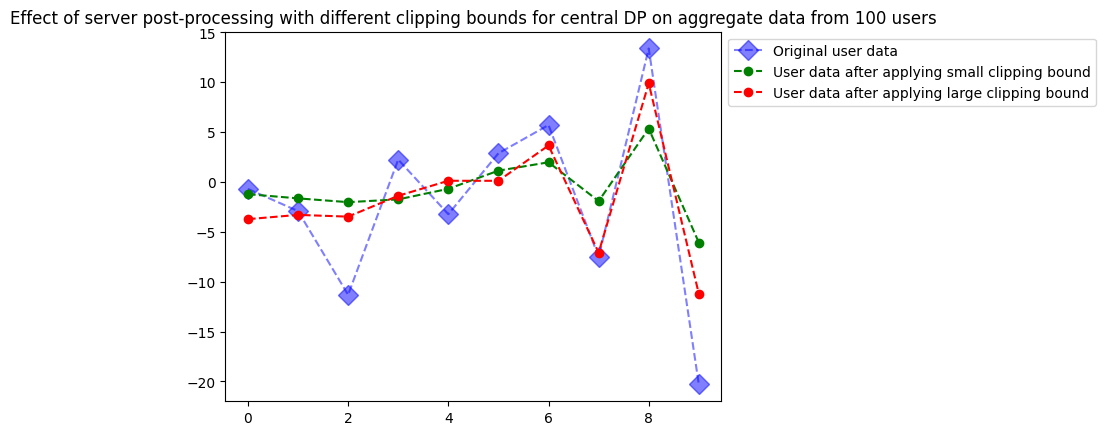

In [17]:
# Plot the original data and the clipped data with added DP noise
plt.plot(true_user_statistics['weights'], 'D--', markersize=10, color='blue', alpha=0.5, label='Original user data')
plt.plot(noised_aggregate_statistics_small_clipping['weights'], 'o--', color='green', label='User data after applying small clipping bound')
plt.plot(noised_aggregate_statistics_large_clipping['weights'], 'o--', color='red', label='User data after applying large clipping bound')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
_ = plt.title('Effect of server post-processing with different clipping bounds for central DP on aggregate data from 100 users')

In [18]:
diff_small_clipping_bound = (true_user_statistics['weights'] - noised_aggregate_statistics_small_clipping['weights'])
diff_large_clipping_bound = (true_user_statistics['weights'] - noised_aggregate_statistics_large_clipping['weights'])
print(f"MSE using small clipping bound: {torch.linalg.norm(diff_small_clipping_bound, ord=2):.4f}")
print(f"MSE using large clipping bound: {torch.linalg.norm(diff_large_clipping_bound, ord=2):.4f}")

MSE using small clipping bound: 20.6405
MSE using large clipping bound: 14.2115


In this example, a large clipping bound results in a smaller SNR (i.e. smaller error) with respect to the original data, compared with using a smaller clipping bound. In general, you need to do hyperparameter tuning to find good privacy hyperparameters. In particular, the clipping bound and the cohort size will need to be tuned.

[Adaptive clipping] (https://arxiv.org/pdf/1905.03871.pdf), `pfl.privacy.adaptive_clipping.AdaptiveClippingGaussianMechanism`, is a technique to learn the clipping bound which ensures the data of a particular quantile of users is clipped. This technique removes the need to tune the clipping bound, at the cost of using a very small amount of the privacy budget to find the required clipping bound from the data.

### 2.3 Include privacy mechanisms in list of postprocessors input to `Backend`.

Next we go back to showing the basic steps of how to use privacy mechanisms for PFL.

First, set up the train and val federated datasets, which also need to be input to the `Backend` object. In this example we are using synthetic datas which is generated using `sklearn.datasets.make_classification`.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

from pfl.data import ArtificialFederatedDataset, get_data_sampler
from pfl.data.dataset import Dataset


# create train and val artificial federated datasets
n_samples = 1000
train_val_split = 0.8
n_features = 8
n_classes = 2
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=4, n_classes=n_classes)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train data shape: X:{X_train.shape}, y:{y_val.shape}')
print(f'Val data shape: X:{X_val.shape}, y:{y_val.shape}')

# Create data sampler to sample each artificial user dataset as a random subset of the original dataset
train_data_sampler = get_data_sampler(sample_type="random", max_bound=len(X_train))
val_data_sampler = get_data_sampler(sample_type="random", max_bound=len(X_val))

# Option 1: Create an artificial federated dataset where each user dataset has constant size of 10
sample_dataset_len = lambda: 10

train_federated_dataset = ArtificialFederatedDataset.from_slices(
    data=[X_train, y_train], 
    data_sampler=train_data_sampler,
    sample_dataset_len=sample_dataset_len,
)

val_federated_dataset = ArtificialFederatedDataset.from_slices(
    data=[X_val, y_val], 
    data_sampler=val_data_sampler,
    sample_dataset_len=sample_dataset_len,
)

central_data = Dataset(raw_data=[X_val, y_val])

Train data shape: X:(800, 8), y:(200,)
Val data shape: X:(200, 8), y:(200,)


Next define the model to be used for PFL training. This model is generated using a helper method `model.pytorch.dnn`.

We also define a model to be used for FL training, i.e. without DP noise, for comparison.

In [20]:
from model.pytorch import dnn
from pfl.model.pytorch import PyTorchModel

from copy import deepcopy

# PFL model
pfl_pytorch_model = dnn((n_features), (10,20), n_classes)
print(f'PFL model: \n{pfl_pytorch_model}')
pfl_params = [p for p in pfl_pytorch_model.parameters() if p.requires_grad]

central_learning_rate = 1.0

pfl_model = PyTorchModel(model=pfl_pytorch_model,
            local_optimizer_create=torch.optim.SGD,
            central_optimizer=torch.optim.SGD(pfl_params, central_learning_rate))

# FL model
fl_pytorch_model = deepcopy(pfl_pytorch_model)
fl_params = [p for p in fl_pytorch_model.parameters() if p.requires_grad]
fl_model = PyTorchModel(model=fl_pytorch_model,
            local_optimizer_create=torch.optim.SGD,
            central_optimizer=torch.optim.SGD(fl_params, central_learning_rate))

PFL model: 
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=8, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=20, bias=True)
  (4): ReLU()
  (5): Linear(in_features=20, out_features=2, bias=True)
)


Next, input the postprocessor list, which includes a central privacy mechanism, along with the federated datasets into `SimulatedBackend`.

In [21]:
from pfl.aggregate.simulate import SimulatedBackend

cohort_size = 100
central_num_iterations = 40
sampling_probability = cohort_size / len(X_train)
epsilon = 2
delta = 1e-8
clipping_bound = 0.5

pld_accountant = PLDPrivacyAccountant(
    num_compositions=num_epochs,
    sampling_probability=sampling_probability,
    mechanism='gaussian',
    epsilon=epsilon,
    delta=delta)

# instantiate a Gaussian noise mechanism using the privacy accountant
pld_gaussian_noise_mechanism = GaussianMechanism.from_privacy_accountant(
    accountant=pld_accountant, clipping_bound=clipping_bound)

# wrap the noise mechanism with CentrallyAppliedPrivacyMechanism to make it a central privacy mechanism
pld_central_privacy = CentrallyAppliedPrivacyMechanism(pld_gaussian_noise_mechanism)

postprocessors = [pld_central_privacy]

pfl_simulated_backend = SimulatedBackend(
    training_data=train_federated_dataset,
    val_data=val_federated_dataset,
    postprocessors=postprocessors)

### 2.4 Run FL training of a model with and without DP

First we train the model with DP. Second, we train the model without DP.

We use the Federated Averaging algorithm (`pfl.algorithm.FederatedAveraging`) to train the model.

In [22]:
# PFL training: train with DP

from pfl.algorithm import FederatedAveraging, NNAlgorithmParams
from pfl.callback import CentralEvaluationCallback, AggregateMetricsToDisk
from pfl.hyperparam import NNTrainHyperParams, NNEvalHyperParams


model_train_params = NNTrainHyperParams(
    local_learning_rate=0.05,
    local_num_epochs=2,
    local_batch_size=5)

# Do full-batch evaluation to run faster.
model_eval_params = NNEvalHyperParams(local_batch_size=None)

evaluation_frequency = 5
algorithm_params = NNAlgorithmParams(
    central_num_iterations=central_num_iterations,
    evaluation_frequency=evaluation_frequency,
    train_cohort_size=cohort_size,
    val_cohort_size=20)

pfl_callbacks = [CentralEvaluationCallback(central_data, model_eval_params, evaluation_frequency), AggregateMetricsToDisk(output_path='pfl_training_metrics/metrics.csv')]

algorithm = FederatedAveraging()

In [23]:
# PFL training using DP

pfl_model = algorithm.run(
    backend=pfl_simulated_backend,
    model=pfl_model,
    algorithm_params=algorithm_params,
    model_train_params=model_train_params,
    model_eval_params=model_eval_params,
    callbacks=pfl_callbacks,
    send_metrics_to_platform=True)

/Users/ainecahill/Dev/pfl/pfl-research/tutorials/../pfl/internal/ops/pytorch_ops.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(v, device=get_default_device()).add(


Metrics at iteration 0 ():
    Central val | loss                                : 0.6609676361083985
    Central val | accuracy                            : 0.67
    Central val | number of data points               : 200
    Train population | number of devices              : 100
    Train population | number of data points          : 10.0
    Train population | loss before local training     : 0.6535045127868653
    Train population | accuracy before local training : 0.689
    Train population | loss after local training      : 0.6104731450080871
    Train population | accuracy after local training  : 0.792
    Central DP | l2 norm bound                        : 0.5
    Central DP | fraction of clipped norms            : 0.0
    Central DP | norm before clipping                 : 0.08949462216347456
    Train population | total weight                   : 1.0
    Central DP | DP noise std. dev. on summed stats   : 1.7939567565917969
    Central DP | signal-to-DP-noise ratio on summed

In [24]:
# FL training, without using DP

# remove central privacy from postprocessors
simulated_backend = SimulatedBackend(
    training_data=train_federated_dataset,
    val_data=val_federated_dataset,
    postprocessors=[])

# change path to which to save metrics
fl_callbacks = [CentralEvaluationCallback(central_data, model_eval_params, evaluation_frequency), AggregateMetricsToDisk(output_path='fl_training_metrics/metrics.csv')]

fl_model = algorithm.run(
    backend=simulated_backend,
    model=fl_model,
    algorithm_params=algorithm_params,
    model_train_params=model_train_params,
    model_eval_params=model_eval_params,
    callbacks=fl_callbacks)

Metrics at iteration 0 ():
    Central val | loss                                : 0.6609676361083985
    Central val | accuracy                            : 0.67
    Central val | number of data points               : 200
    Train population | number of devices              : 100
    Train population | number of data points          : 10.0
    Train population | loss before local training     : 0.6591247510910034
    Train population | accuracy before local training : 0.667
    Train population | loss after local training      : 0.6159456977844239
    Train population | accuracy after local training  : 0.767
    Train population | total weight                   : 1.0
    Number of parameters                              : 352
    Val population | number of devices                : 20
    Val population | number of data points            : 10.0
    Val population | loss before local training       : 0.6558606433868408
    Val population | accuracy before local training   : 0.69
    Le

Let's compare the performance of the two models: one trained with DP (i.e. with PFL) and one trained without DP (i.e. just FL)

In [25]:
import pandas as pd
pfl_metrics = pd.read_csv('pfl_training_metrics/metrics.csv')
fl_metrics = pd.read_csv('fl_training_metrics/metrics.csv')

pfl_metrics = pfl_metrics.dropna(subset=['Central val | accuracy'])
fl_metrics = fl_metrics.dropna(subset=['Central val | accuracy'])

Text(0.5, 0, 'Training iteration')

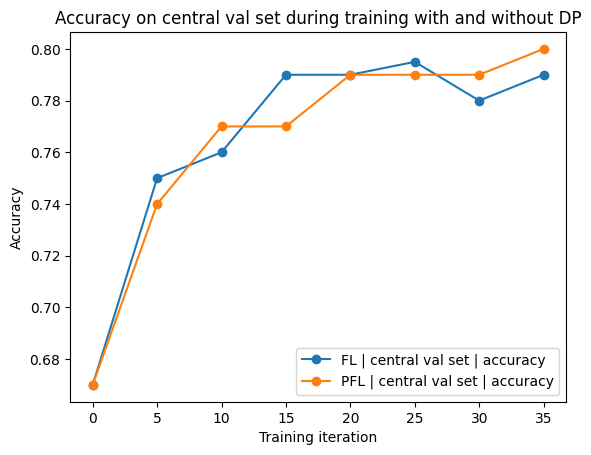

In [26]:
plt.plot(fl_metrics['central_iteration'], fl_metrics['Central val | accuracy'], 'o-', label='FL | central val set | accuracy')
plt.plot(pfl_metrics['central_iteration'], pfl_metrics['Central val | accuracy'], 'o-', label='PFL | central val set | accuracy')
plt.legend()
plt.title('Accuracy on central val set during training with and without DP')
plt.ylabel('Accuracy')
plt.xlabel('Training iteration')

Text(0.5, 0, 'Training iteration')

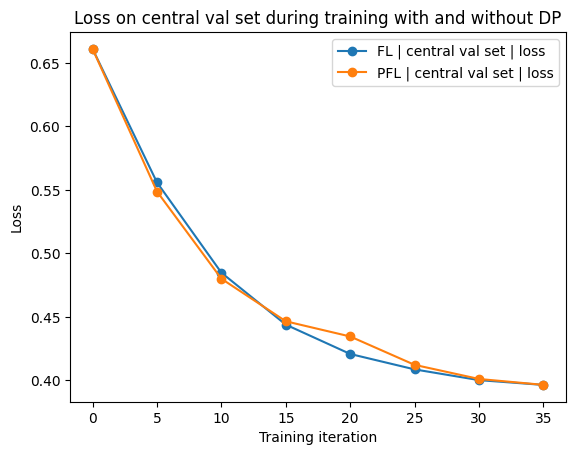

In [27]:
plt.plot(fl_metrics['central_iteration'], fl_metrics['Central val | loss'], 'o-', label='FL | central val set | loss')
plt.plot(pfl_metrics['central_iteration'], pfl_metrics['Central val | loss'], 'o-', label='PFL | central val set | loss')
plt.legend()
plt.title('Loss on central val set during training with and without DP')
plt.ylabel('Loss')
plt.xlabel('Training iteration')

In this example, you can see that training with and without DP yields similar performance in terms of loss and accuracy on the validation set.

There is much literature on the challenges of training with DP. The heterogeneity of the federated dataset, the size of the model to be trained and the desired level of privacy will all impact the success of training a model with federated learning and DP.

In general, you will see that performance without DP (FL) is better than performance with DP (PFL). The difference in performance between training with and without DP can be reduced by tuning the hyperparameters related to DP and the signal-to-noise (SNR) ratio of aggregated model updates in each training iteration. These parameters particularly include `cohort_size` and `clipping_bound`.

## 3. How to tune privacy parameters for PFL

When using DP with federated learning, we have seen that there are additional hyperparameters used for the privacy mechanism. These additional privacy hyperparameters include: 
- epsilon
- delta
- clipping bound
- cohort size per iteration (a larger cohort size is required to achieve the same, or sufficient, SNR compared with FL training without DP)
- sampling probability, for sampling users in each iteration (sampling probability = cohort size / population size)
- DP noise mechanism (e.g. Gaussian)
- central or local DP or central DP implemented in a distributed way

We typically start by defining the target epsilon and delta values to be used during FL training. Privacy amplification by subsampling often cannot be implemented in practice as it is hard to ensure a fixed sampling probability applies throughout training. For this reason, you may or may not be able to modify sampling_probability for your experiments.

1. Firstly, run FL experiments to determine hyperparameters that work well when DP is NOT applied.
2. Next, compute the l2 norm of user model updates being aggregated during FL without using DP. This gives an idea of the distribution of sensitivities of model updates of users. You can now decide on how to set the clipping bound in order to clip some target percentage of data aggregated over users. Knowing the range of sensitivites of user data will also help provide a range of values over which to tune the clipping bound during PFL hyperparameter tuning. Note that it is often better to clip the model updates from more users than to have too loose a clipping bound.
3. We recommend jointly tuning the clipping bound and the cohort size to find the best parameters for FL with DP.

Note that there is a trick that can be used to speed up your FL experiments with DP when a large cohort size is to be used.

In FL experiments with DP, there is almost a perfect correlation between reducing the DP noise to be added and increasing the cohort size to be used in an experiment. This means that instead of increasing the cohort size to very large numbers above 1000 in order to make your model converge well, you can instead simulate a large cohort size by decreasing proportionally the DP noise to be added during model training.

If you would like to test FL training with DP with a large cohort size called `target_cohort_size`, but you only want to run the simulation with a smaller cohort size `cohort_size`, where `cohort_size` < `target_cohort_size`, then the standard deviation of Gaussian DP noise to be added is 
$$
\sigma_{\text{cohort size}} * \frac{\text{cohort size}}{\text{target cohort size}}
$$

Using `pfl` this trick can easily be implemented using the `noise_scale` parameter of privacy accountants in `pfl.privacy.privacy_accountant` by setting `noise_scale = cohort_size / noise_cohort_size`.

Alternatively, you can set the `noise_cohort_size` parameter of the helper function `utils.argument_parsing.parse_mechanism` equal to the target cohort size in order for this trick to be used when defining a privacy mechanism.